In [ ]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv
/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv


In [ ]:
!pip install --quiet nltk tensorflow scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    average_precision_score, jaccard_score
)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
folder = '/kaggle/input/fake-news-detection-datasets/News _dataset/'

df_real = pd.read_csv(os.path.join(folder, 'True.csv'))
df_fake = pd.read_csv(os.path.join(folder, 'Fake.csv'))

# Label: 1=real, 0=fake
df_real['label'] = 1
df_fake['label'] = 0

# Keep only text and label
df = pd.concat([df_real[['text','label']], df_fake[['text','label']]], ignore_index=True)
print(df.label.value_counts())
df.head()

label
0    23481
1    21417
Name: count, dtype: int64


,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenizer & Padding
max_vocab = 20000
max_len   = 200

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq  = tokenizer.texts_to_sequences(X_test)

train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
test_pad  = pad_sequences(test_seq,  maxlen=max_len, padding='post', truncating='post')

In [ ]:
def build_rnn(vocab_size, embed_dim=64, units=64):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_len),
        GRU(units),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy']
    )
    return model

def build_bi_rnn(vocab_size, embed_dim=64, units=64):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_len),
        Bidirectional(GRU(units)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy']
    )
    return model

def build_lstm(vocab_size, embed_dim=64, units=64):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_len),
        LSTM(units),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy']
    )
    return model

def build_bi_lstm(vocab_size, embed_dim=64, units=64):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_len),
        Bidirectional(LSTM(units)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy']
    )
    return model

In [ ]:
callbacks = [
    # EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

epochs = 10
batch = 64

models = {
    'RNN': build_rnn(max_vocab),
    'Bi-RNN': build_bi_rnn(max_vocab),
    'LSTM': build_lstm(max_vocab),
    'Bi-LSTM': build_bi_lstm(max_vocab)
}

for name, model in models.items():
    print(f"\nTraining {name}")
    model.fit(
        train_pad, y_train,
        validation_data=(test_pad, y_test),
        epochs=epochs, batch_size=batch,
        callbacks=callbacks, verbose=2
    )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training RNN
Epoch 1/10
562/562 - 10s - 18ms/step - accuracy: 0.8271 - loss: 0.4073 - val_accuracy: 0.9618 - val_loss: 0.1571
Epoch 2/10
562/562 - 5s - 9ms/step - accuracy: 0.9775 - loss: 0.0953 - val_accuracy: 0.9937 - val_loss: 0.0335
Epoch 3/10
562/562 - 5s - 9ms/step - accuracy: 0.9938 - loss: 0.0334 - val_accuracy: 0.9939 - val_loss: 0.0338
Epoch 4/10
562/562 - 5s - 9ms/step - accuracy: 0.9959 - loss: 0.0220 - val_accuracy: 0.9968 - val_loss: 0.0185
Epoch 5/10
562/562 - 5s - 9ms/step - accuracy: 0.9955 - loss: 0.0213 - val_accuracy: 0.9955 - val_loss: 0.0236
Epoch 6/10
562/562 - 5s - 9ms/step - accuracy: 0.9959 - loss: 0.0177 - val_accuracy: 0.9954 - val_loss: 0.0232
Epoch 7/10
562/562 - 5s - 9ms/step - accuracy: 0.9941 - loss: 0.0270 - val_accuracy: 0.9942 - val_loss: 0.0314
Epoch 8/10
562/562 - 5s - 9ms/step - accuracy: 0.9931 - loss: 0.0279 - val_accuracy: 0.9944 - val_loss: 0.0263
Epoch 9/10
562/562 - 5s - 9ms/step - accuracy: 0.9963 - loss: 0.0146 - val_accuracy: 0.9951 - va

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate(y_true, y_pred, y_prob, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    ap_pos = average_precision_score(y_true, y_prob)
    ap_neg = average_precision_score(1-y_true, 1-y_prob)
    mAP = (ap_pos + ap_neg)/2
    iou = jaccard_score(y_true, y_pred)
    print(f"mAP: {mAP:.4f}, Jaccard IoU: {iou:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== RNN Evaluation ===
              precision    recall  f1-score   support

           0     0.9938    0.9951    0.9945      4696
           1     0.9946    0.9932    0.9939      4284

    accuracy                         0.9942      8980
   macro avg     0.9942    0.9942    0.9942      8980
weighted avg     0.9942    0.9942    0.9942      8980



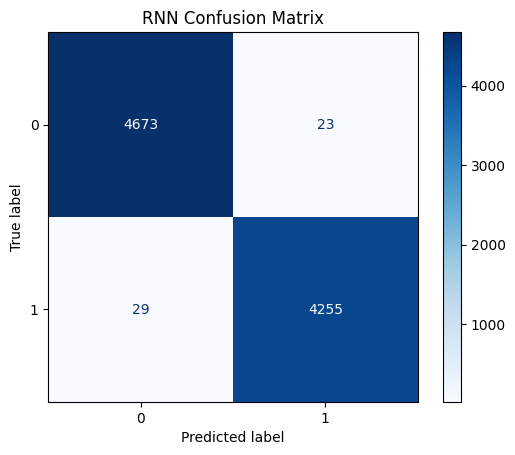

mAP: 0.9981, Jaccard IoU: 0.9879
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

=== Bi-RNN Evaluation ===
              precision    recall  f1-score   support

           0     0.9983    0.9989    0.9986      4696
           1     0.9988    0.9981    0.9985      4284

    accuracy                         0.9986      8980
   macro avg     0.9986    0.9985    0.9985      8980
weighted avg     0.9986    0.9986    0.9986      8980



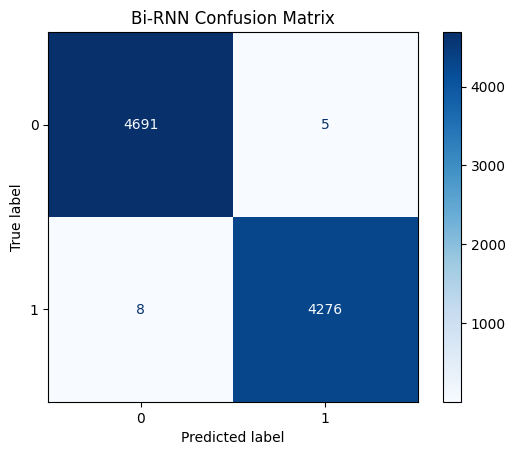

mAP: 0.9999, Jaccard IoU: 0.9970
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== LSTM Evaluation ===
              precision    recall  f1-score   support

           0     0.9970    0.9825    0.9897      4696
           1     0.9812    0.9967    0.9889      4284

    accuracy                         0.9893      8980
   macro avg     0.9891    0.9896    0.9893      8980
weighted avg     0.9894    0.9893    0.9893      8980



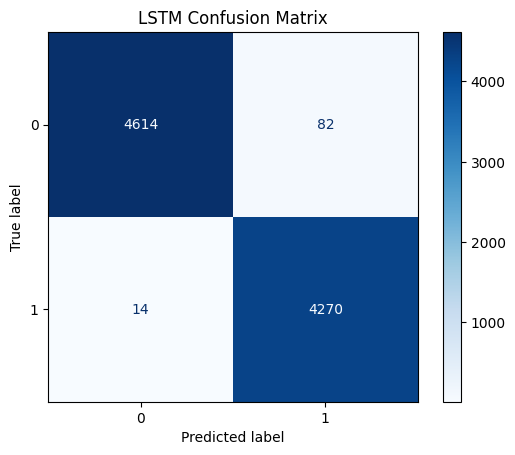

mAP: 0.9978, Jaccard IoU: 0.9780
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

=== Bi-LSTM Evaluation ===
              precision    recall  f1-score   support

           0     0.9987    0.9989    0.9988      4696
           1     0.9988    0.9986    0.9987      4284

    accuracy                         0.9988      8980
   macro avg     0.9988    0.9988    0.9988      8980
weighted avg     0.9988    0.9988    0.9988      8980



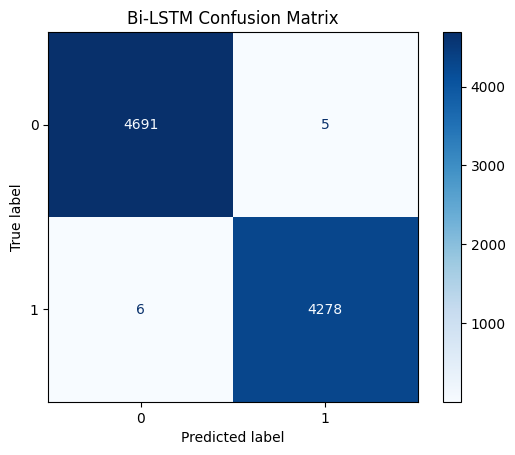

mAP: 0.9994, Jaccard IoU: 0.9974


In [ ]:
for name, model in models.items():
    probs = model.predict(test_pad).flatten()
    preds = (probs > 0.5).astype(int)
    evaluate(y_test, preds, probs, name)